In [1]:
import nilearn
from nilearn.glm.first_level import first_level_from_bids
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import FirstLevelModel
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

In [2]:
# data folder
data_dir='../InSpePosNegData/BIDS_2023E/' 
# derivatives folder (preprocessed data)
derivatives_dir='derivatives'  

# name of experiment
task_label = 'boldinnerspeech'
# run the function that can gather all the needed info from a BIDS folder
models, models_run_imgs, models_events, models_confounds = \
    first_level_from_bids(
        data_dir, task_label, derivatives_folder=derivatives_dir, n_jobs=6, verbose=0,
        img_filters = [('desc', 'preproc')])

/work/neuro_4/neuro_env/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:1148: UserWarning: 'slice_time_ref' provided (0.0) is different from the value found in the BIDS dataset (0.462).
Note this may lead to the wrong model specification.
  warn(


In [3]:
index_118 = 1

# confirming that index X is participant 118
print(models[index_118])
print(models_events[index_118])

# no way to tell whether the confounds and models_run_img are participant 118, lets hope so
print(models_confounds[index_118])
print(models_run_imgs[index_118])

# select participant 118
models_118 = models[index_118]
run_imgs_118 = models_run_imgs[index_118]

FirstLevelModel(n_jobs=6, subject_label='0118', t_r=1)
[         onset  duration trial_type cued_word_pos cued_word_neg response  \
0     1.007677  0.688785     IMG_NS     wonderful      pathetic      NaN   
1     6.313886  0.699925     IMG_PS     wonderful      pathetic      NaN   
2    11.630686  0.699659     IMG_BI     wonderful      pathetic        b   
3    17.947682  0.699587     IMG_PS     wonderful      pathetic      NaN   
4    24.264465  0.699933     IMG_NS     wonderful      pathetic      NaN   
..         ...       ...        ...           ...           ...      ...   
85  453.935742  0.700058     IMG_NS     wonderful      pathetic      NaN   
86  458.255634  0.696938     IMG_NS     wonderful      pathetic      NaN   
87  464.569964  0.700019     IMG_NS     wonderful      pathetic      NaN   
88  468.888167  0.698301     IMG_PS     wonderful      pathetic      NaN   
89  473.203578  0.699721     IMG_BI     wonderful      pathetic        b   

          RT  run   ID         

In [4]:
# Subset confounds
confound_friston24 = ['trans_x','trans_y','trans_z',
                 'rot_x','rot_y','rot_z','trans_x_derivative1','trans_y_derivative1','trans_z_derivative1',
                 'rot_x_derivative1','rot_y_derivative1','rot_z_derivative1','trans_x_power2','trans_y_power2','trans_z_power2',
                 'rot_x_power2','rot_y_power2','rot_z_power2']

confound_friston24_GSR = ['global_signal','global_signal_derivative1','global_signal_power2','global_signal_derivative1_power2','trans_x','trans_y','trans_z',
                 'rot_x','rot_y','rot_z','trans_x_derivative1','trans_y_derivative1','trans_z_derivative1',
                 'rot_x_derivative1','rot_y_derivative1','rot_z_derivative1','trans_x_power2','trans_y_power2','trans_z_power2',
                 'rot_x_power2','rot_y_power2','rot_z_power2']

# Subset confounds with selection
for ii in range(len(models_confounds)):
    confounds1 = models_confounds[ii][:].copy()
    for i in range(len(confounds1)):
        confounds2 = confounds1[i].copy()
        confounds2 = confounds2[confound_friston24_GSR]
        #Removing NAs in the first row.
        confounds2.loc[0,:] = confounds2.loc[1,:]
        confounds1[i] = confounds2
    models_confounds[ii][:] = confounds1

# Set confounds for participant 118
confounds_118 = models_confounds[index_118]

In [5]:
events_sub= ['onset','duration','trial_type']

# Subset model events with selection
for ii in range(len(models_events)):
    events1=models_events[ii][:]
    for i in range(len(events1)):
        events2=events1[i]
        events2=events2[events_sub]
        events1[i]=events2
        # Rename trials to make contrasting easier
        events1[i].replace({'IMG_NS': 'N', 'IMG_PS': 'P', 'IMG_NO': 'N', 'IMG_PO': 'P','IMG_BI': 'B'}, inplace = True)

       
    models_events[ii][:]=events1

# Set events for participant 118
events_118 = models_events[index_118]

/tmp/ipykernel_10697/2374799310.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events1[i].replace({'IMG_NS': 'N', 'IMG_PS': 'P', 'IMG_NO': 'N', 'IMG_PO': 'P','IMG_BI': 'B'}, inplace = True)
/tmp/ipykernel_10697/2374799310.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events1[i].replace({'IMG_NS': 'N', 'IMG_PS': 'P', 'IMG_NO': 'N', 'IMG_PO': 'P','IMG_BI': 'B'}, inplace = True)
/tmp/ipykernel_10697/2374799310.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [6]:
lsa_dm=[]

# Changing the model for a single participant (the first):
for ii in range(len(events_118)):
    # Sort onsets by trial type to make later processing easier
    # events_118[ii].sort_values(by=['trial_type'], inplace=True)
    # N=number of events
    N=events_118[ii].shape[0]
    # time frame with 490 scans with 1s TR:
    t_fmri = np.linspace(0, 490,490,endpoint=False)
    # We have to create a dataframe with onsets/durations/trial_types
    # No need for modulation!
    trials = pd.DataFrame(events_118[ii], columns=['onset'])
    trials.loc[:, 'duration'] = 0.7
    trials.loc[:, 'trial_type'] = [events_118[ii]['trial_type'][i-1]+'_'+'t_'+str(i).zfill(3)  for i in range(1, N+1)]

    # lsa_dm = least squares all design matrix
    lsa_dm.append(make_first_level_design_matrix(
        frame_times=t_fmri,  # we defined this earlier 
        events=trials,
        add_regs=models_confounds[0][ii], #Add the confounds from fmriprep
        hrf_model='glover',
        drift_model='cosine'  
    ))

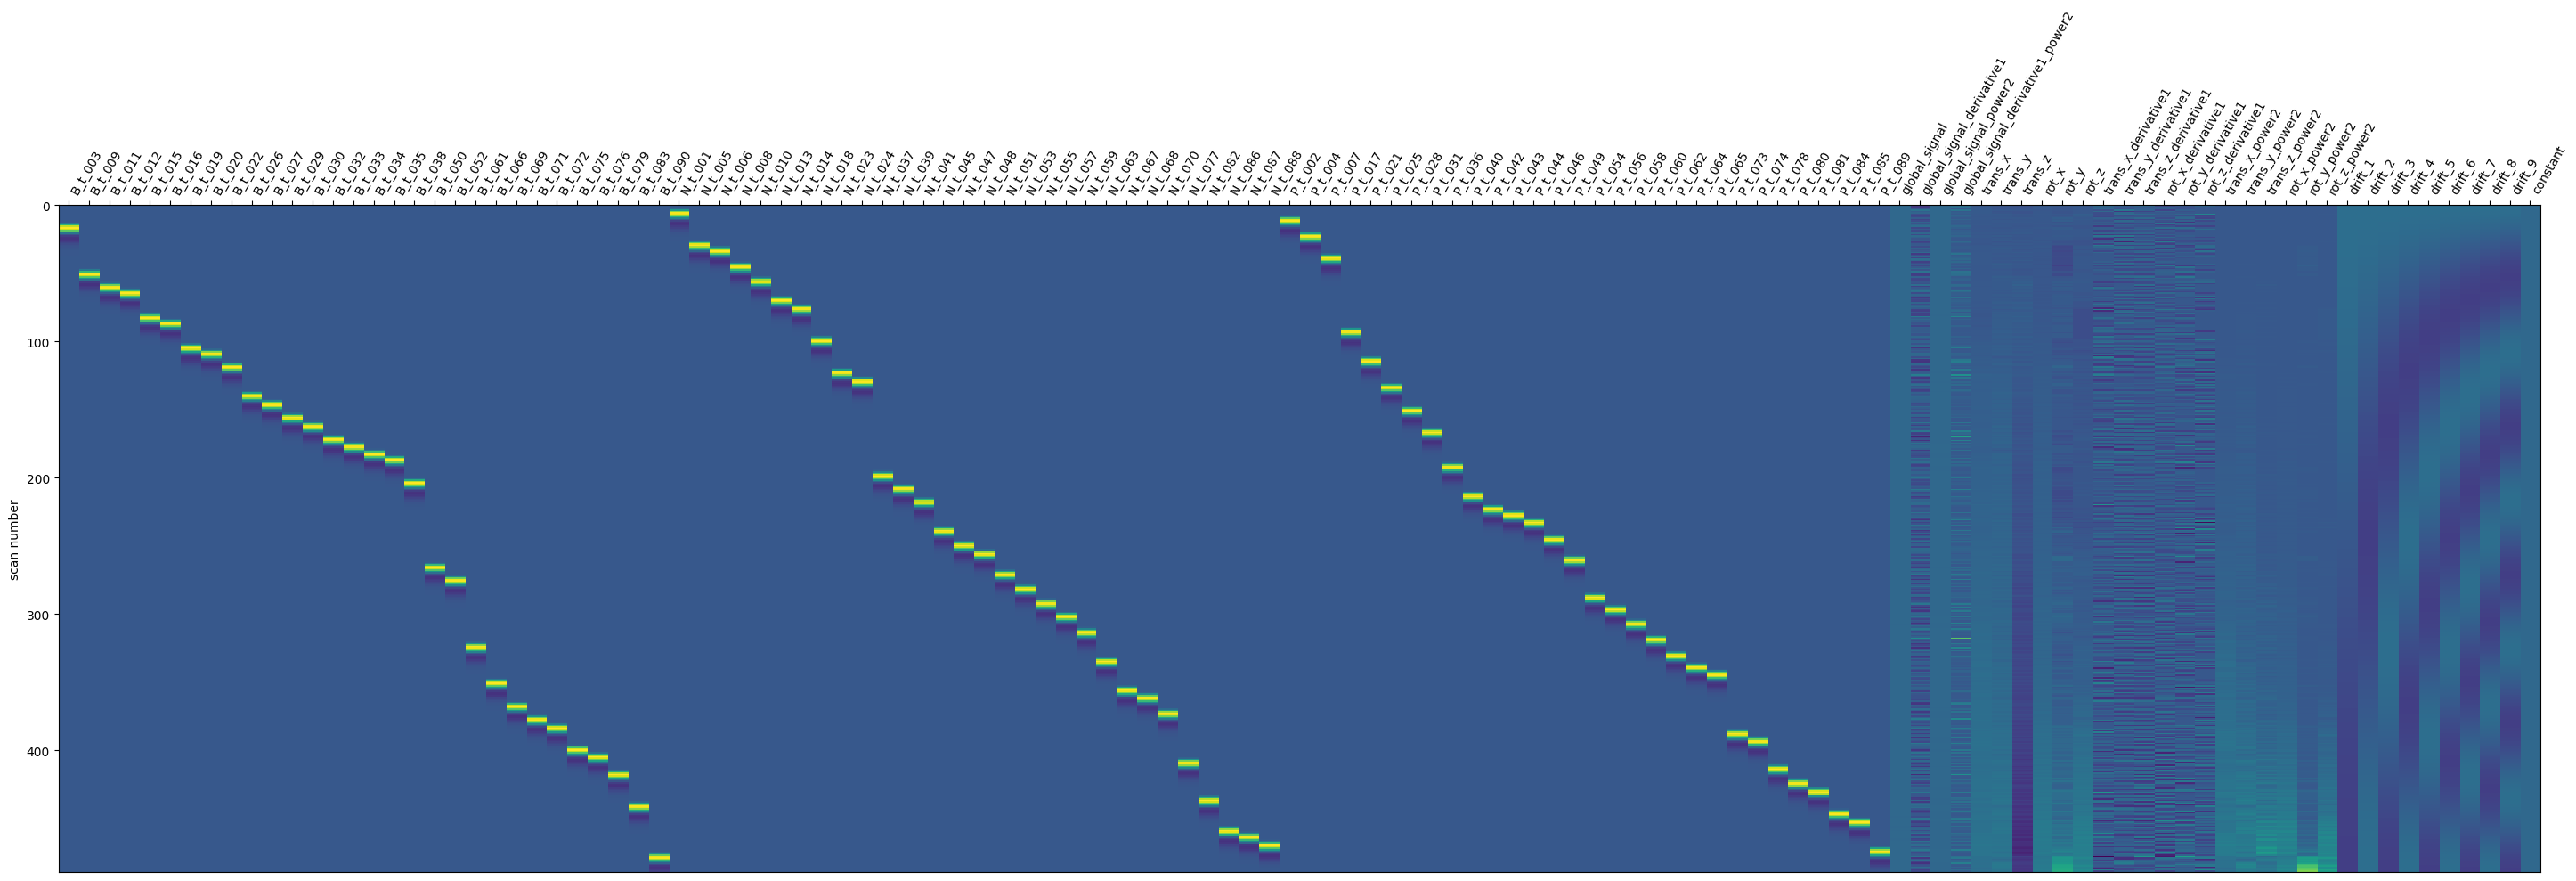

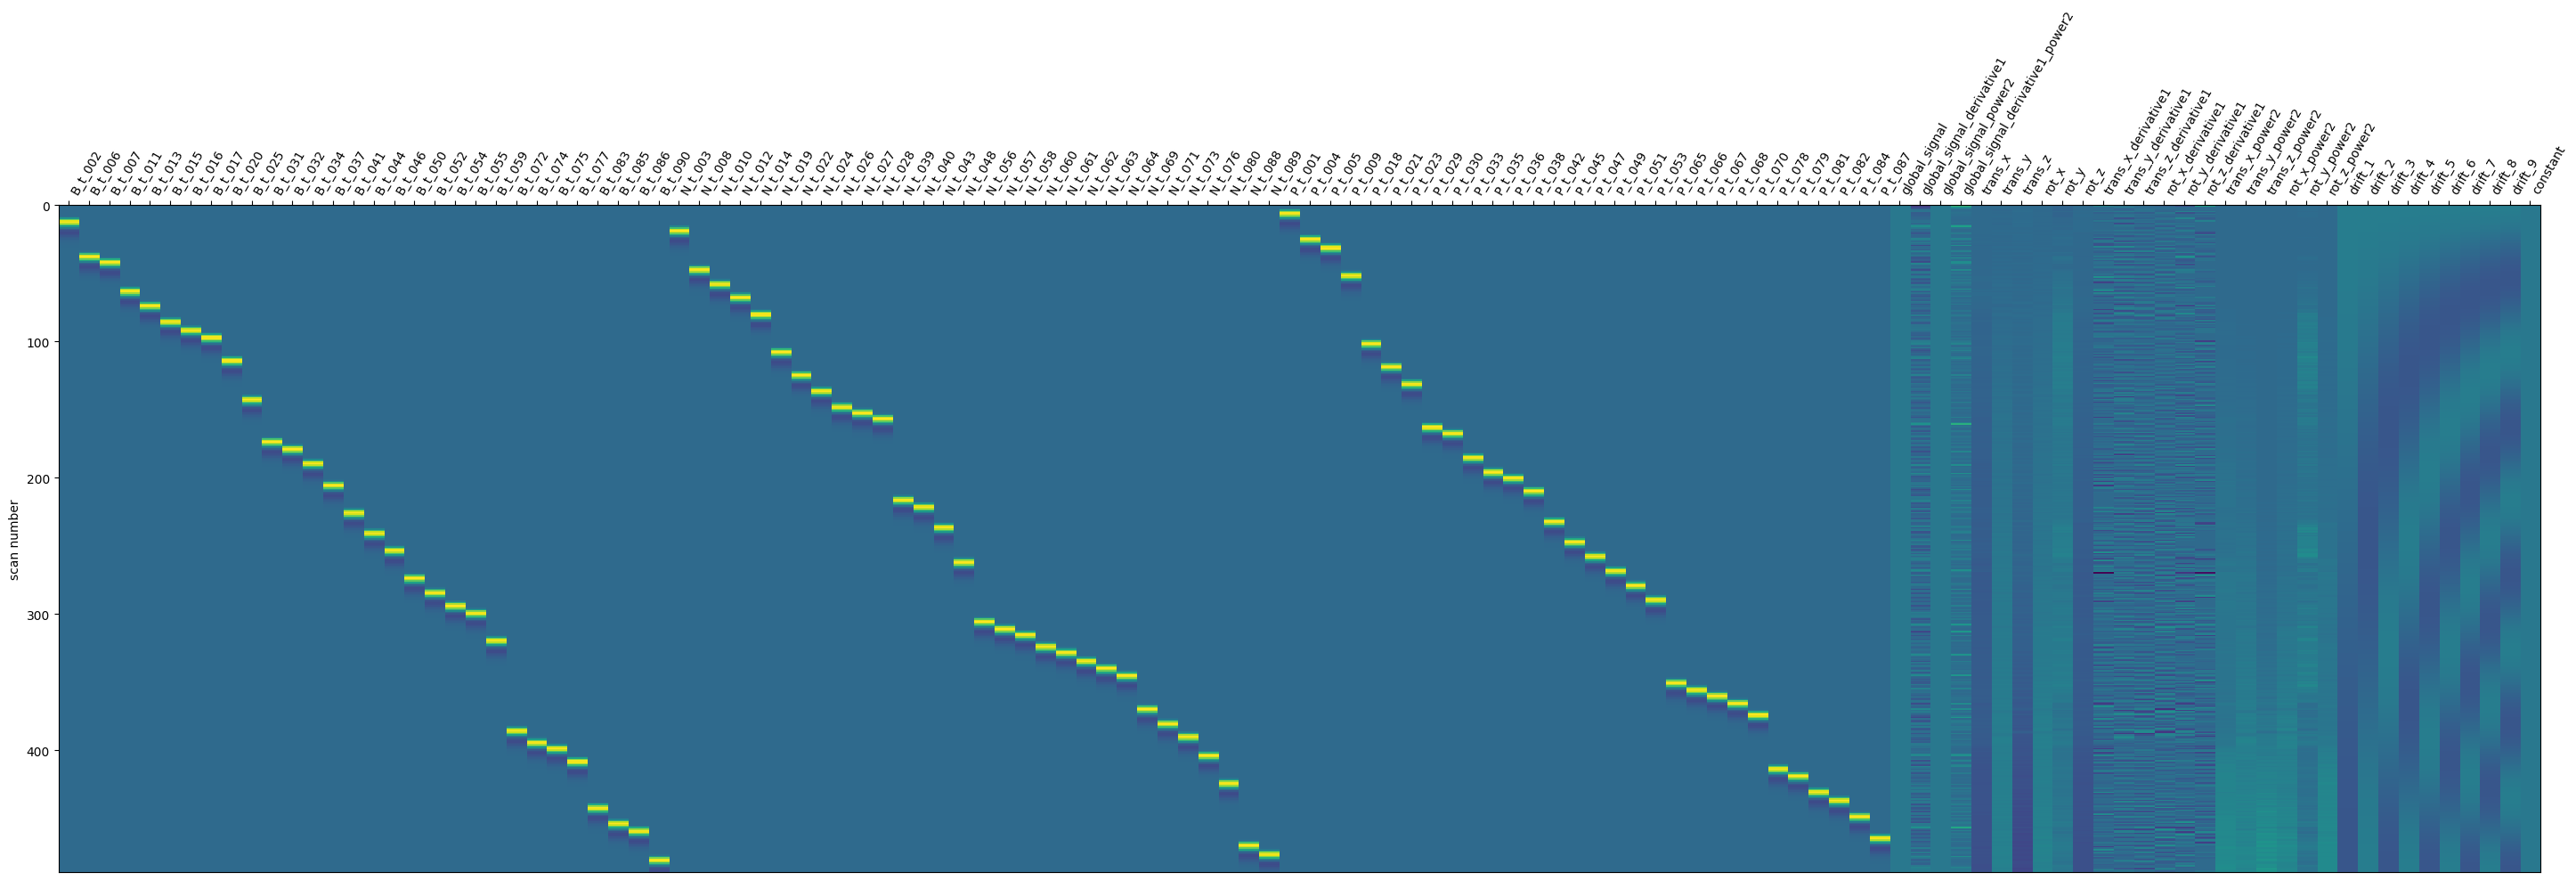

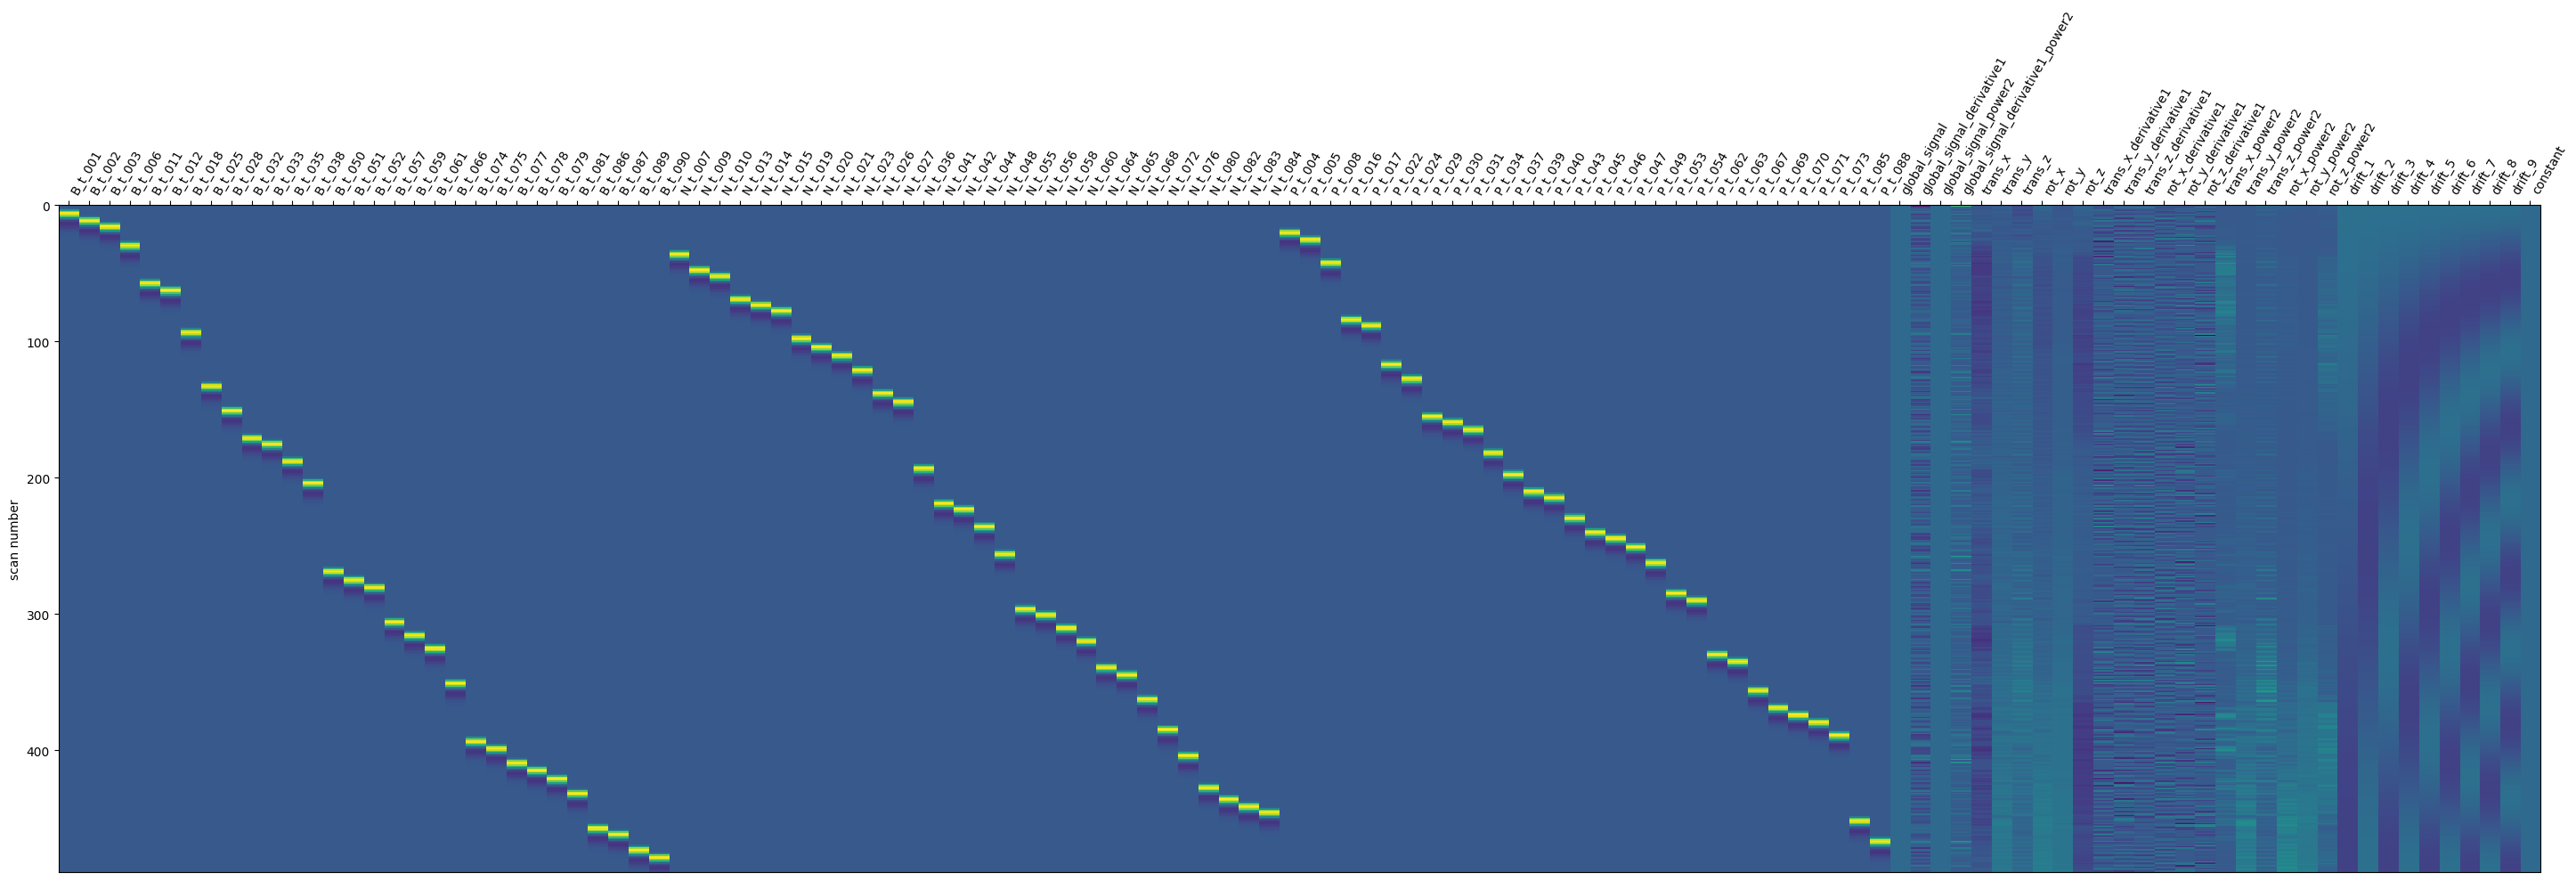

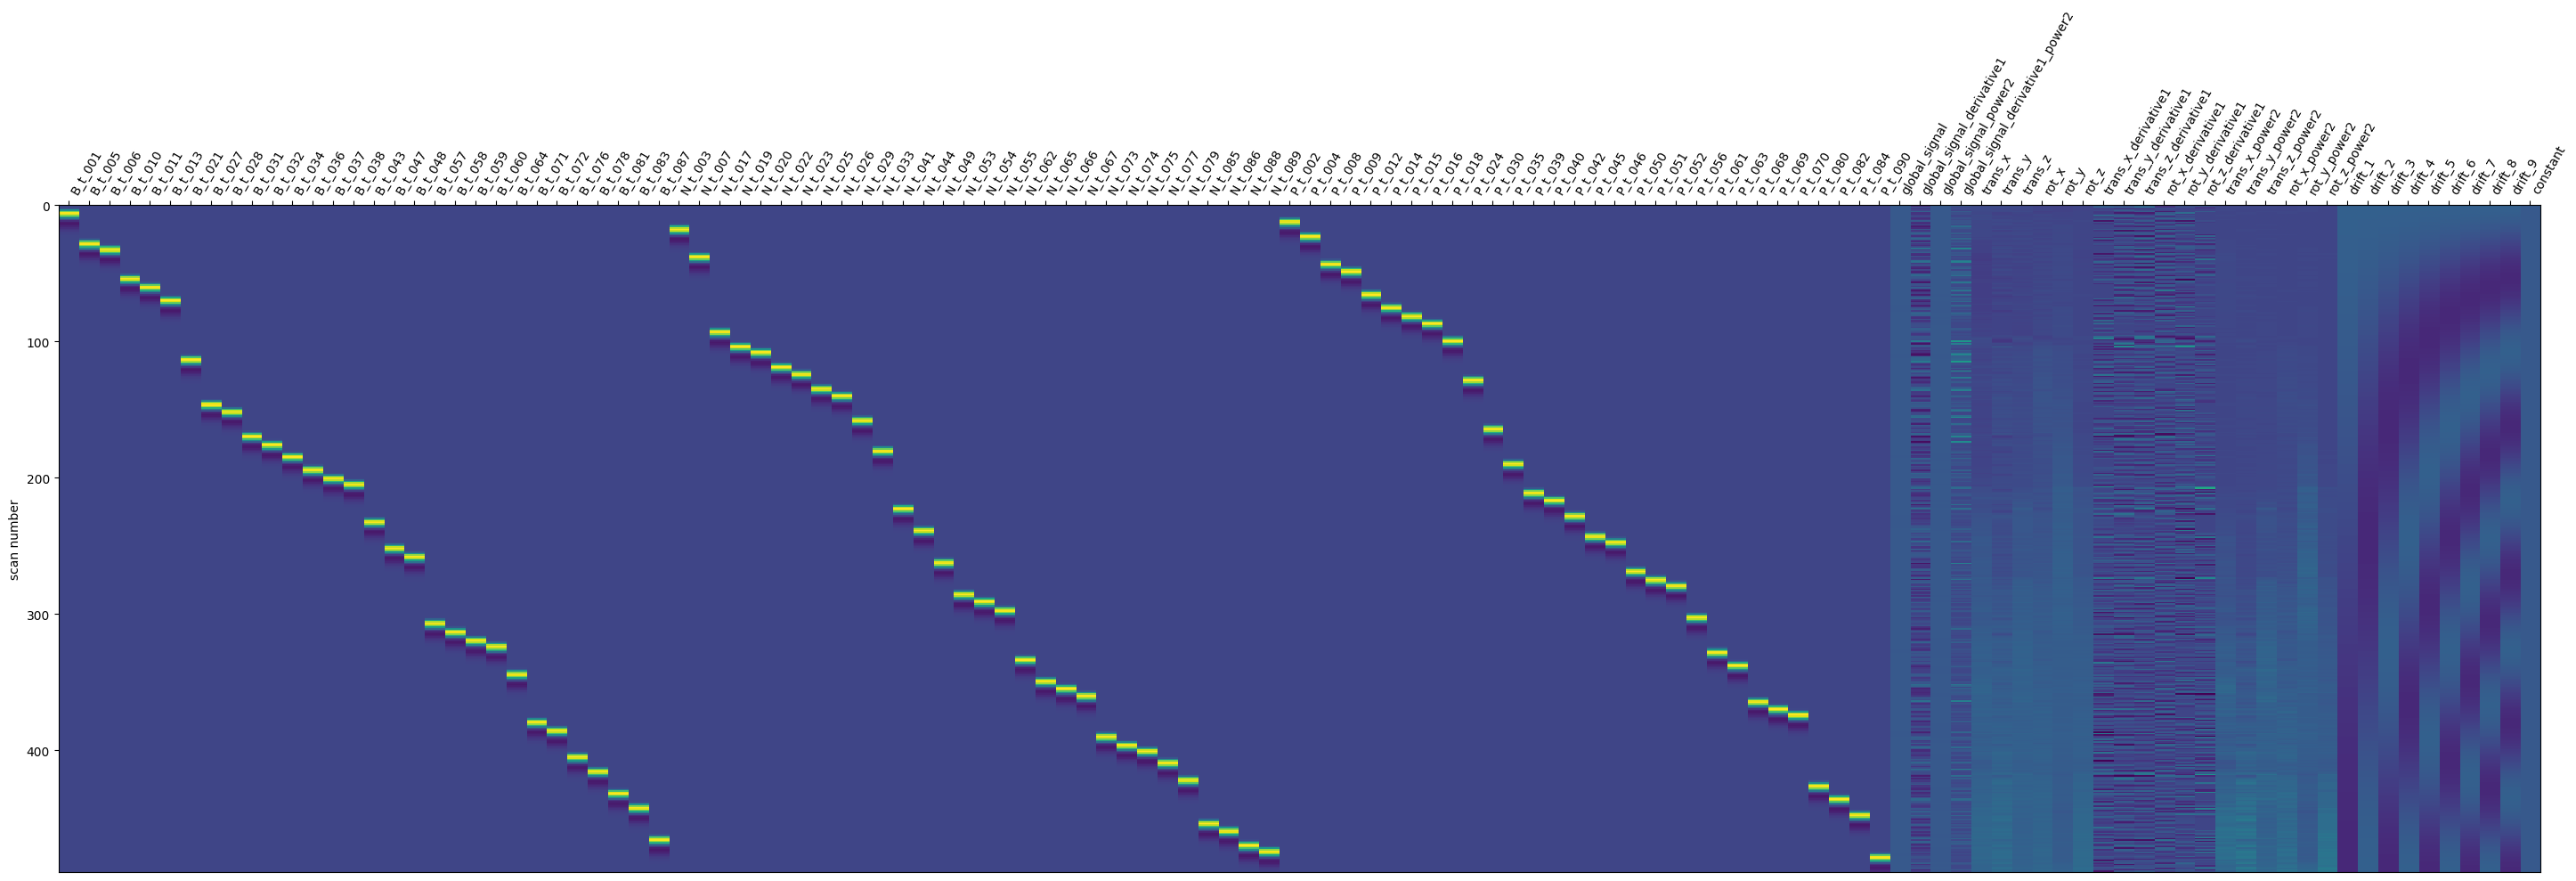

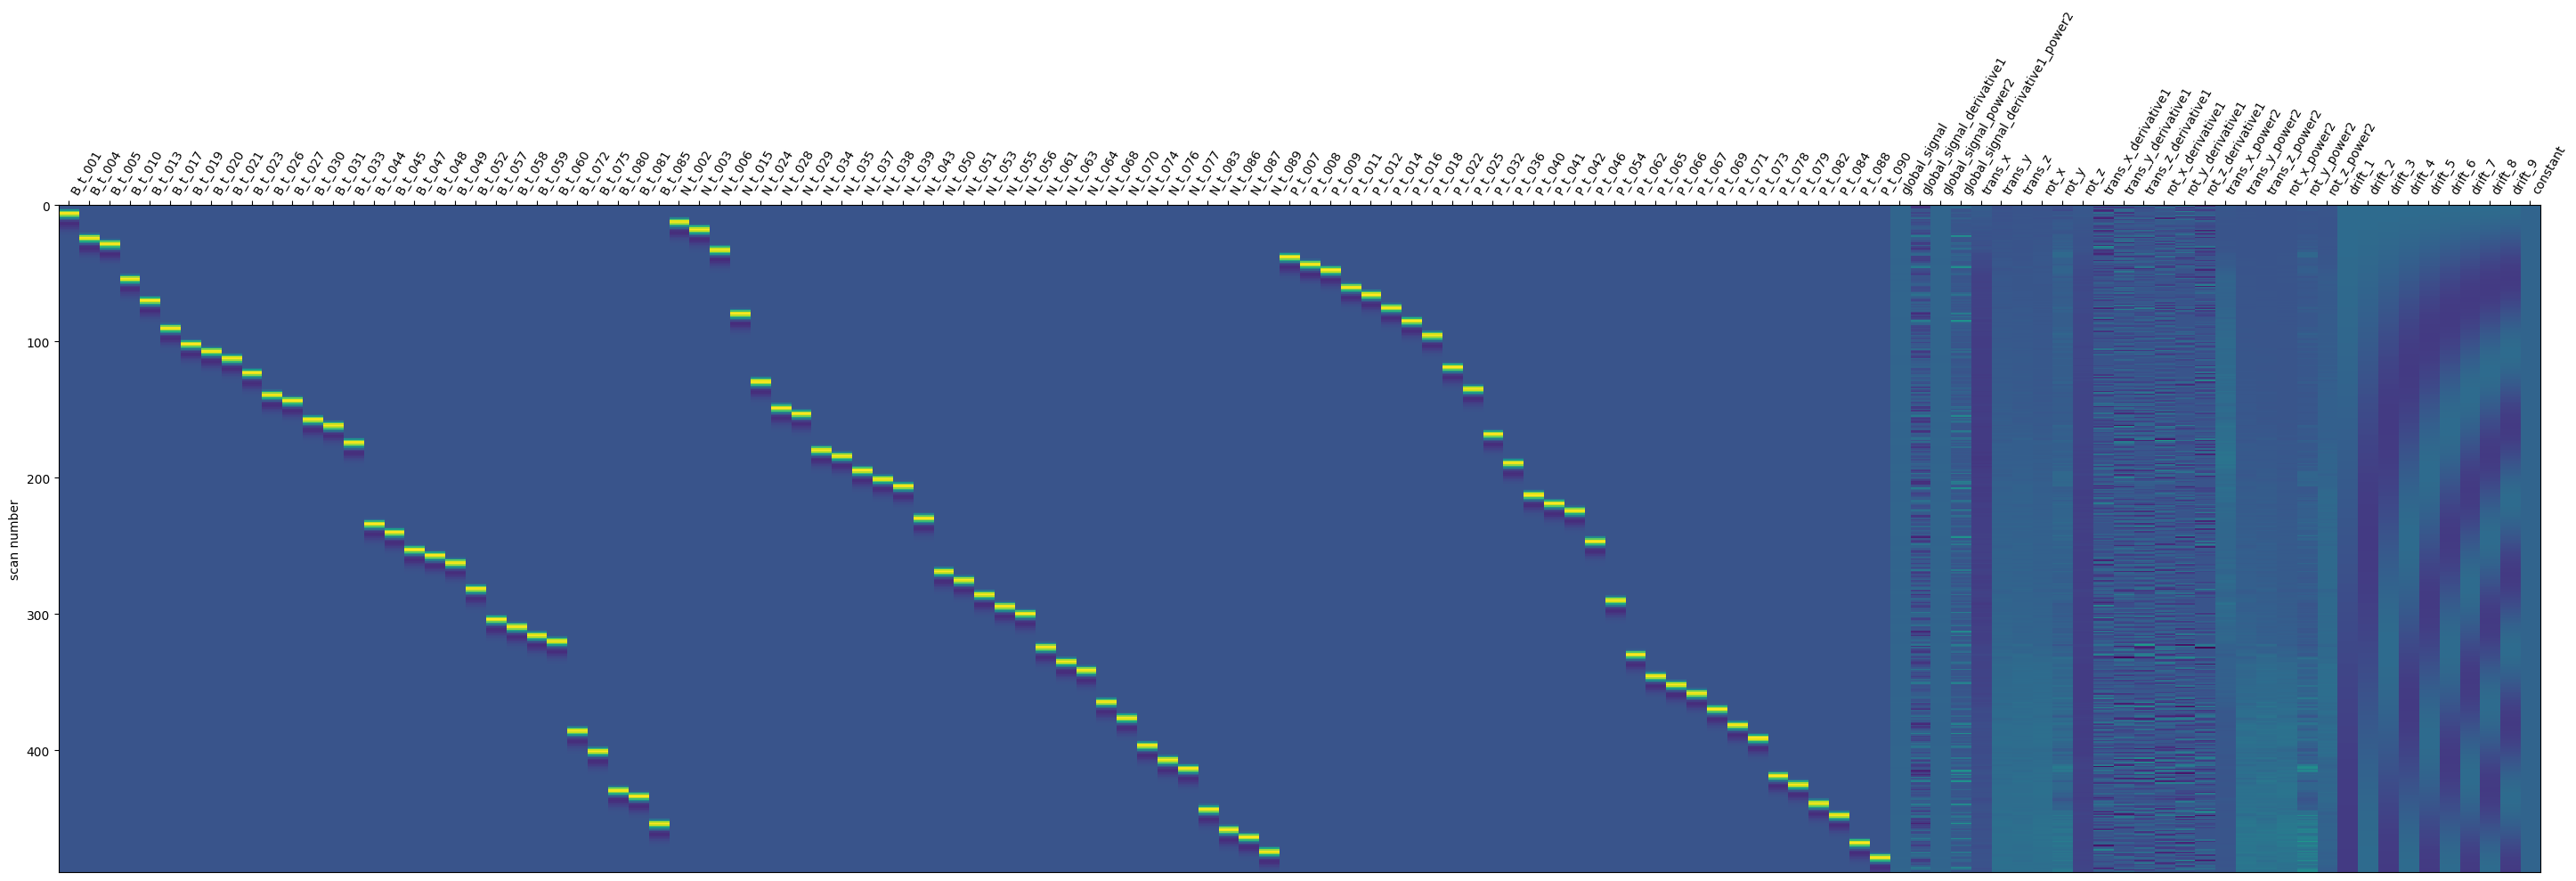

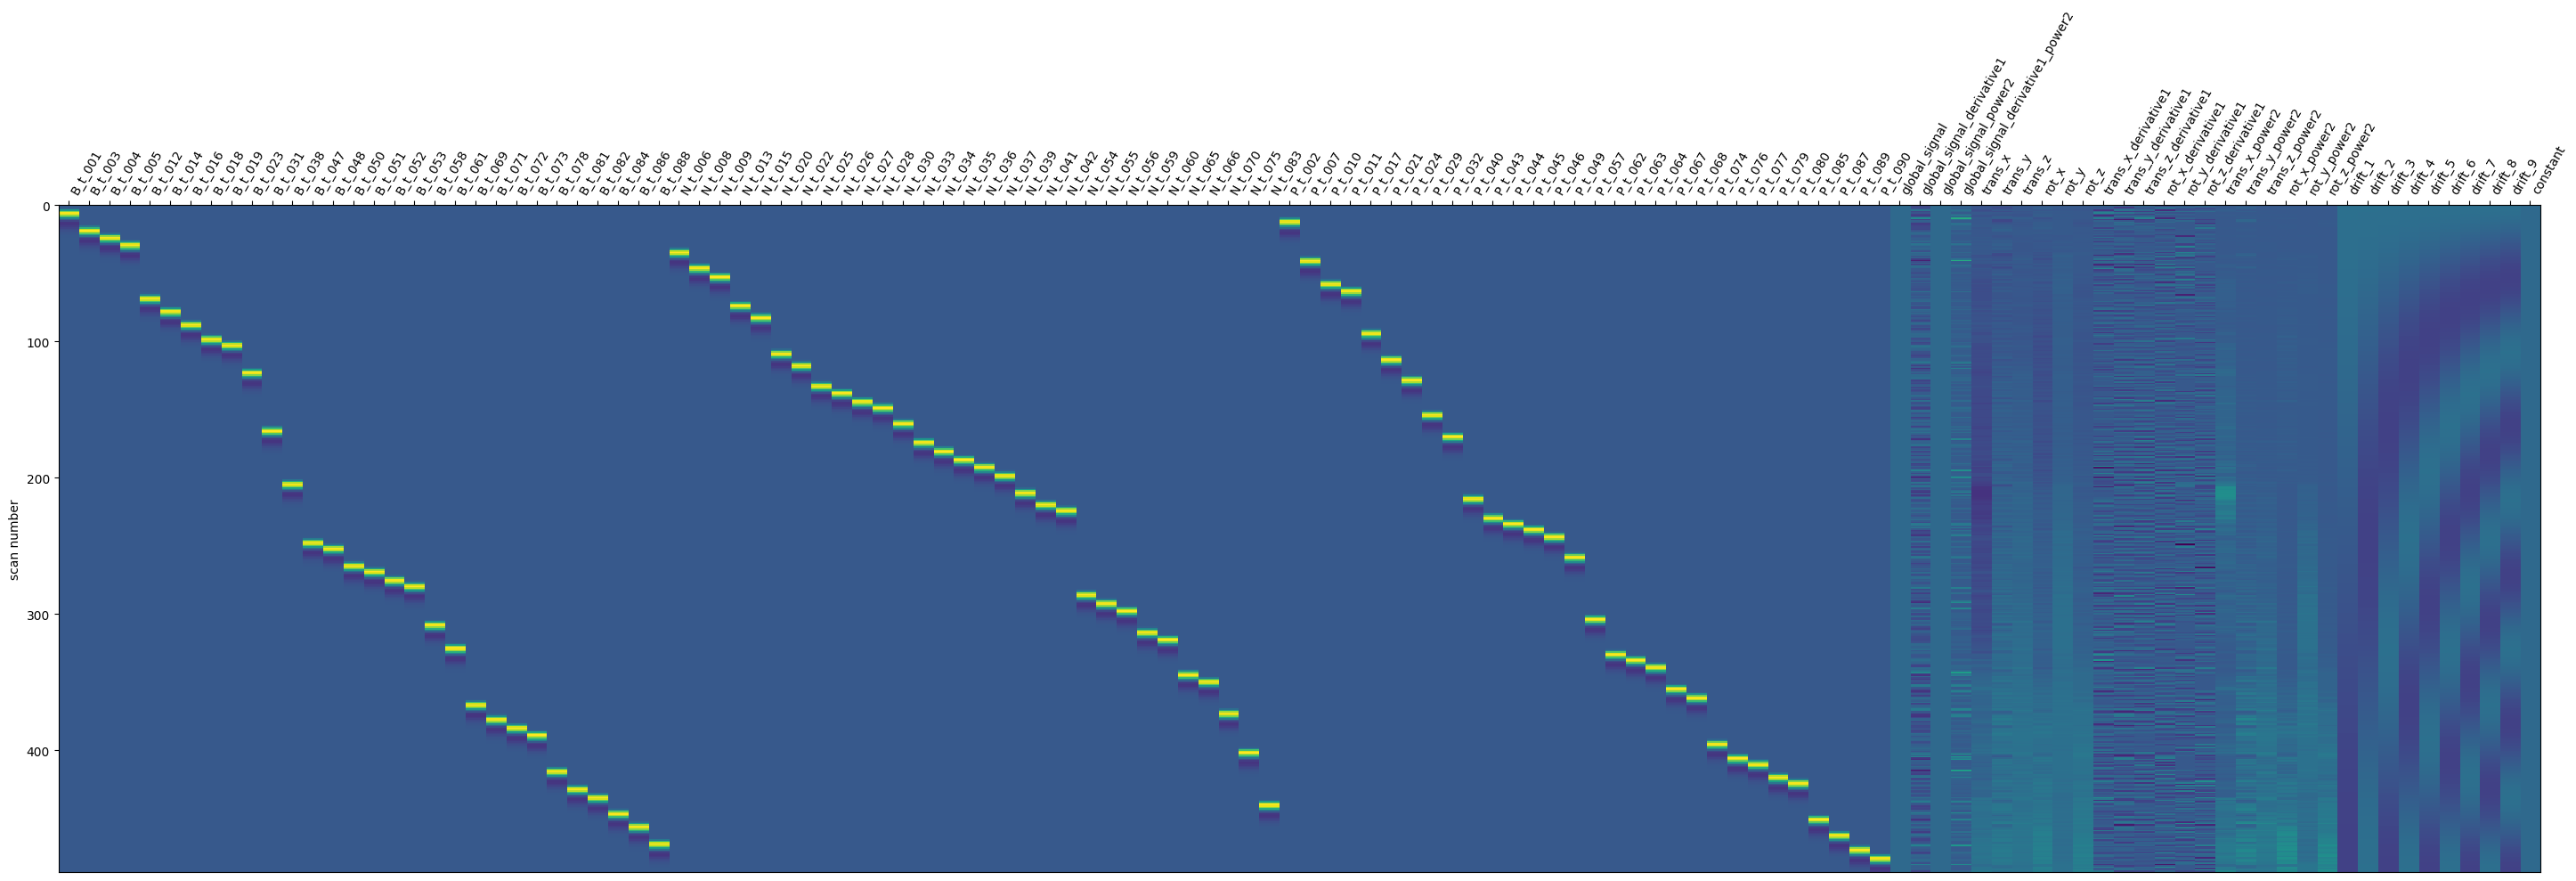

In [7]:
for ii in range(len(events_118)):
    plot_design_matrix(lsa_dm[ii]);

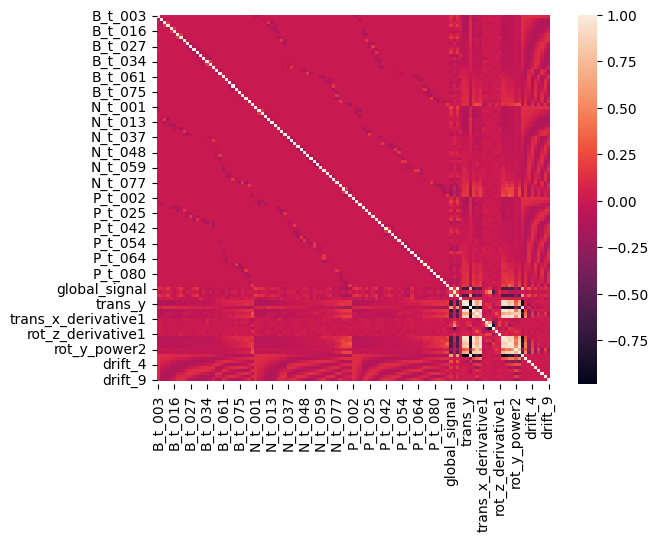

In [8]:
dm_corr=lsa_dm[0].corr()
p1 = sns.heatmap(dm_corr)

In [9]:
model1=[]
for ii in range(len(events_118)):
    imgs1 = run_imgs_118[ii]
    model1.append(FirstLevelModel())
    #Fit the model
    print('Fitting GLM: ', ii+1)
    model1[ii].fit(imgs1,design_matrices=lsa_dm[ii])

Fitting GLM:  1
Fitting GLM:  2
Fitting GLM:  3
Fitting GLM:  4
Fitting GLM:  5
Fitting GLM:  6


In [10]:
b_maps = []
conditions_label = []

for ii in range(len(events_118)):
    N=events_118[ii].shape[0]
    #Make an identity matrix with N= number of trials
    contrasts=np.eye(N)
    #Find difference between columns in design matrix and number of trials
    dif=lsa_dm[ii].shape[1]-contrasts.shape[1]
    #Pad with zeros
    contrasts=np.pad(contrasts, ((0,0),(0,dif)),'constant')
    print('Making contrasts for session : ', ii+1)
    print('Number of contrasts : ', N)
    for i in range(N):
        #Add a beta-contrast image from each trial
        b_maps.append(model1[ii].compute_contrast(contrasts[i,], output_type='effect_size'))
        # Make a variable with condition labels for use in later classification
        conditions_label.append(lsa_dm[ii].columns[i])

Making contrasts for session :  1
Number of contrasts :  90
Making contrasts for session :  2
Number of contrasts :  90
Making contrasts for session :  3
Number of contrasts :  90
Making contrasts for session :  4
Number of contrasts :  90
Making contrasts for session :  5
Number of contrasts :  90


In [ ]:
# Saving the objects:
f = open('../data/01_beta_maps.pkl', 'wb')
pickle.dump([model1, lsa_dm, conditions_label, b_maps], f)
f.close()